# Model Notebook

The purpose of this notebook is to create various models and try and determine which one works best for the project task. As well as trying various models, I will also experiment with different features and perform feature engineering to try and get the best predictors. As I go through this process I will try and explore the data further and continue with EDA.

I will start by importing the necessary libraries

In [25]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.mc_functions as mcf

%matplotlib inline

Store training features and labels in dataframes. I will then combine the two dataframes to create one with both the features and labels.

In [2]:
vals = pd.read_csv('../training_set_values')
labels = pd.read_csv('../training_set_labels')

Now I will drop 'Unnamed: 0' from both dataframes and join on the id column.

In [5]:
df = labels.merge(vals, on='id', how='outer')

In [6]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
df.shape

(59400, 41)

Now I can drop the id column since all the data is corresponding correctly.

In [8]:
df.drop('id', axis=1, inplace=True)

I also know from my initial data exploration that I can drop the num_private and scheme_name columns.

In [9]:
df.drop(['num_private', 'scheme_name'], axis=1, inplace=True)

Okay great, the base dataframe is all set up. As I stated at the beginning of the notebook, what I really want to do is experiment with some different features before focusing on a specific model.

## Train Test Split

First I need to separate the features and target variables

In [127]:
# target
y = df['status_group']
# features
X = df.drop('status_group', axis=1)

In [197]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [58]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

Next I will drop the redundant columns from both X_train and X_test as well as the columns I don't think will be very useful.

In [129]:
to_drop = ['funder', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'district_code',
            'lga', 'ward', 'public_meeting', 'recorded_by', 'permit', 'extraction_type', 'extraction_type_class',
            'management', 'payment_type', 'quality_group', 'quantity_group', 'source', 'source_class',
            'waterpoint_type']

In [198]:
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

In [131]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'basin',
       'region', 'population', 'scheme_management', 'construction_year',
       'extraction_type_group', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_type', 'waterpoint_type_group'],
      dtype='object')

Great now these are the columns I will work with from here on out. Not all of these will be in the final model but I will experiment with these going forward.

One thing I think would really influence the quality of the pump is how old it is. Although there is not a column for age, I can use the construction_year and date_recorded to engineer an age column. The only problem is construction_year has a lot of 0, so I will need to take care of that first. I will start by replacing all 0 values in construction_year with NAN.

In [83]:
X_train['construction_year'].value_counts()

2010.0    2133
2008.0    2124
2009.0    2027
2000.0    1682
2007.0    1275
2006.0    1174
2003.0    1035
2011.0    1003
2012.0     883
2004.0     874
2002.0     850
1978.0     840
1995.0     815
2005.0     802
1990.0     781
1998.0     781
1999.0     779
1985.0     740
1980.0     666
1996.0     648
1984.0     631
1982.0     597
1994.0     593
1972.0     558
1974.0     535
1992.0     524
1997.0     521
1993.0     480
1988.0     423
2001.0     423
1983.0     393
1986.0     355
1975.0     349
1976.0     318
1970.0     316
1991.0     256
1989.0     242
1987.0     238
1981.0     182
1977.0     165
1979.0     158
1973.0     146
2013.0     134
1971.0     120
1960.0      87
1963.0      76
1967.0      74
1968.0      58
1969.0      49
1964.0      31
1962.0      27
1965.0      16
1961.0      16
1966.0      14
Name: construction_year, dtype: int64

In [84]:
X_train.isna().sum()

amount_tsh                   0
date_recorded                0
gps_height                   0
installer                 2889
basin                        0
region                       0
population                   0
scheme_management         3102
construction_year        16503
extraction_type_group        0
management_group             0
payment                      0
water_quality                0
quantity                     0
source_type                  0
waterpoint_type_group        0
dtype: int64

Okay now all values in construction_year that were 0 are classified as a missing value. I would assume that pumps in the same general area were constructed about the same time. So I want to fill the missing values for construction_year with the average construction year for that given region.

In [85]:
X_train['region'].value_counts()

Iringa           4254
Shinyanga        3977
Mbeya            3659
Kilimanjaro      3466
Morogoro         3223
Arusha           2692
Kagera           2662
Mwanza           2475
Kigoma           2255
Pwani            2115
Ruvuma           2105
Tanga            2052
Dodoma           1755
Singida          1664
Mara             1590
Tabora           1578
Rukwa            1454
Mtwara           1374
Manyara          1266
Lindi            1250
Dar es Salaam     654
Name: region, dtype: int64

First I will make a dict that has the average construction year for each region

In [86]:
regions = X_train['region'].unique()

In [87]:
regions

array(['Manyara', 'Dodoma', 'Mbeya', 'Morogoro', 'Mwanza', 'Shinyanga',
       'Kigoma', 'Tanga', 'Iringa', 'Arusha', 'Kagera', 'Singida',
       'Tabora', 'Rukwa', 'Pwani', 'Ruvuma', 'Dar es Salaam',
       'Kilimanjaro', 'Lindi', 'Mtwara', 'Mara'], dtype=object)

In [104]:
X_train.groupby('basin').median()

,amount_tsh,gps_height,population,construction_year
basin,,,,
Internal,0.0,1219.5,1.0,2002.0
Lake Nyasa,0.0,476.0,0.0,2000.0
Lake Rukwa,0.0,0.0,0.0,1989.0
Lake Tanganyika,0.0,873.0,60.0,1997.0
Lake Victoria,0.0,0.0,0.0,1998.0
Pangani,0.0,1164.0,100.0,2000.0
Rufiji,20.0,791.0,54.0,2000.0
Ruvuma / Southern Coast,0.0,340.0,200.0,1996.0
Wami / Ruvu,0.0,73.0,80.0,2004.0


From the information above it looks like a few of the regions do not have any data recorded on them. I think it may be best to drop those.

In [94]:
missing_regions = ['Dodoma', 'Kagera', 'Mbeya', 'Tabora']
total = 0
for region in missing_regions:
    total += len(X_train[X_train['region'] == region])
    total += len(X_test[X_test['region'] == region])
total

12115

So by dropping the rows that have a region listed above I will lose 12115 observations total. That is a lot and I don't think I want to do that.

In [96]:
X_test.groupby('basin').mean()

,amount_tsh,gps_height,population,construction_year
basin,,,,
Internal,200.825753,888.397822,162.522742,1195.631006
Lake Nyasa,532.446312,752.149393,62.330532,985.417367
Lake Rukwa,454.679487,587.322650,161.271368,838.179487
Lake Tanganyika,186.591449,725.044339,266.558987,1129.834521
Lake Victoria,19.990210,314.729320,132.921684,465.326481
Pangani,277.135893,1040.371731,168.533111,1952.550362
Rufiji,680.243598,866.393504,183.497189,1564.235478
Ruvuma / Southern Coast,214.417693,431.325868,275.555431,1905.221725
Wami / Ruvu,349.230769,211.603550,260.873204,1620.712595


In [103]:
X_test.groupby('basin').median()

,amount_tsh,gps_height,population,construction_year
basin,,,,
Internal,0.0,1222,1,2002.0
Lake Nyasa,0.0,0,0,2000.0
Lake Rukwa,0.0,0,0,1989.0
Lake Tanganyika,0.0,915,100,1996.0
Lake Victoria,0.0,0,0,1998.0
Pangani,0.0,1176,90,2000.0
Rufiji,20.0,736,55,2000.0
Ruvuma / Southern Coast,0.0,350,200,1995.0
Wami / Ruvu,0.0,70,85,2003.0


In [101]:
X_train['construction_year'].value_counts()

2010.0    2133
2008.0    2124
2009.0    2027
2000.0    1682
2007.0    1275
2006.0    1174
2003.0    1035
2011.0    1003
2012.0     883
2004.0     874
2002.0     850
1978.0     840
1995.0     815
2005.0     802
1990.0     781
1998.0     781
1999.0     779
1985.0     740
1980.0     666
1996.0     648
1984.0     631
1982.0     597
1994.0     593
1972.0     558
1974.0     535
1992.0     524
1997.0     521
1993.0     480
1988.0     423
2001.0     423
1983.0     393
1986.0     355
1975.0     349
1976.0     318
1970.0     316
1991.0     256
1989.0     242
1987.0     238
1981.0     182
1977.0     165
1979.0     158
1973.0     146
2013.0     134
1971.0     120
1960.0      87
1963.0      76
1967.0      74
1968.0      58
1969.0      49
1964.0      31
1962.0      27
1965.0      16
1961.0      16
1966.0      14
Name: construction_year, dtype: int64

Since there are about 20,000 construction_year values missing, I think setting them as the average year of the construction of pipes in the basin will work fine. I may end up changing this or dropping the age column altogether. So now I will create a dictionary with unique basins and the median construction year, now that I think about it median will be much more accuarate than mean.

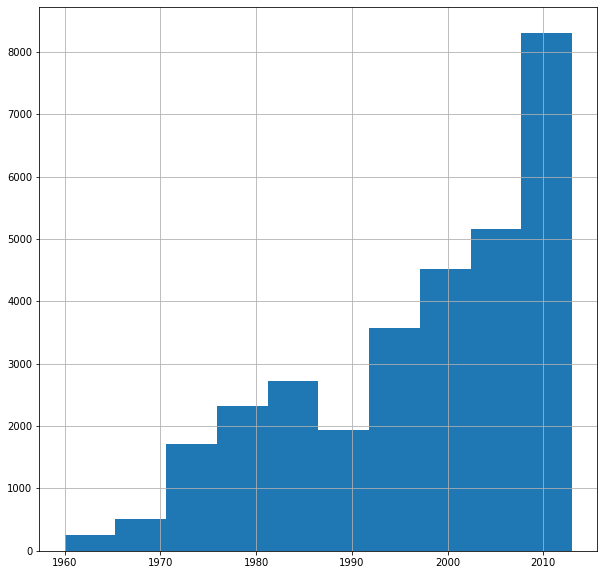

In [105]:
X_train['construction_year'].hist(figsize=(10,10));

Definitely median. Since the distribution of construction year is so skewed median will be a much better value to fill in.

In [106]:
unique_basin = X_train['basin'].unique()

In [107]:
unique_basin

array(['Internal', 'Lake Rukwa', 'Rufiji', 'Wami / Ruvu', 'Lake Victoria',
       'Lake Tanganyika', 'Pangani', 'Lake Nyasa',
       'Ruvuma / Southern Coast'], dtype=object)

In [111]:
med_year_per_basin = {}
for basin in unique_basin:
    med_year = X_train[X_train['basin'] == basin].median()['construction_year']
    med_year_per_basin[basin] = med_year

In [112]:
med_year_per_basin

{'Internal': 2002.0,
 'Lake Rukwa': 1989.0,
 'Rufiji': 2000.0,
 'Wami / Ruvu': 2004.0,
 'Lake Victoria': 1998.0,
 'Lake Tanganyika': 1997.0,
 'Pangani': 2000.0,
 'Lake Nyasa': 2000.0,
 'Ruvuma / Southern Coast': 1996.0}

Great, now I can fill the missing construction year values with the median year in that basin

In [199]:
for idx, row in X_train.iterrows():
    if row['construction_year'] == 0:
        X_train['construction_year'][idx] = med_year_per_basin[row['basin']]

In [155]:
X_train['construction_year'].value_counts()

1998    6960
2000    5012
2002    3373
1997    2795
2010    2133
2008    2124
2009    2027
2004    1725
1989    1414
2007    1275
2006    1174
2003    1035
2011    1003
2012     883
1978     840
1996     822
1995     815
2005     802
1990     781
1999     779
1985     740
1980     666
1984     631
1982     597
1994     593
1972     558
1974     535
1992     524
1993     480
2001     423
1988     423
1983     393
1986     355
1975     349
1976     318
1970     316
1991     256
1987     238
1981     182
1977     165
1979     158
1973     146
2013     134
1971     120
1960      87
1963      76
1967      74
1968      58
1969      49
1964      31
1962      27
1965      16
1961      16
1966      14
Name: construction_year, dtype: int64

Great that worked now I can use the date_recorded column to get the year the water pump was recorded. Then subtract construction_year from that year to get age.

Just found out that date_recorded is not the date the pump was expected but date the row was entered in the dataframe. So to compute age I will just use current_year - construction_year

In [200]:
X_train['current_year'] = pd.datetime.now().year

In [201]:
X_train['date_recorded'] = pd.to_datetime(X_train['date_recorded'], infer_datetime_format=True)

In [160]:
X_train['year'] = X_train['date_recorded'].apply(lambda x: x.year)

In [161]:
X_train['year'].value_counts()

2011    22947
2013    19425
2012     5124
2004       24
Name: year, dtype: int64

In [202]:
X_train['age'] = X_train['current_year'] - X_train['construction_year']

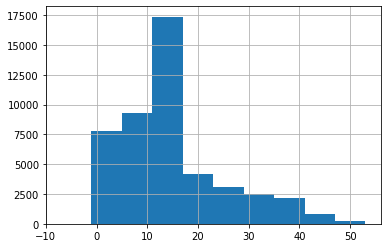

In [163]:
X_train['age'].hist()

Awesome now I have a column that gives the age of the waterpump. Now I want to do the same thing for X_test

In [203]:
for idx, row in X_test.iterrows():
    if row['construction_year'] == 0:
        X_test['construction_year'][idx] = med_year_per_basin[row['basin']]

In [204]:
X_test['current_year'] = pd.datetime.now().year

In [165]:
X_test['date_recorded'] = pd.to_datetime(X_test['date_recorded'], infer_datetime_format=True)

In [166]:
X_test['year'] = X_test['date_recorded'].apply(lambda x: x.year)

In [205]:
X_test['age'] = X_test['current_year'] - X_test['construction_year']

Now I can drop construction_year and date_recorded from both X_train and X_test

In [206]:
X_train.drop(['date_recorded', 'construction_year'], axis=1, inplace=True)
X_test.drop(['date_recorded', 'construction_year'], axis=1, inplace=True)

## Look at other missing values

Now that I have an age column to use, I can look at the other columns that are missing data.

In [169]:
X_train.isna().sum()

amount_tsh                  0
gps_height                  0
installer                2889
basin                       0
region                      0
population                  0
scheme_management        3102
extraction_type_group       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type_group       0
year                        0
age                         0
dtype: int64

For now, I am just going to impute these missing values with the most_frequent. In the future I may go back and do something similar to what I did with construction_year

In [207]:
X_train.drop('scheme_management', axis=1, inplace=True)
X_test.drop('scheme_management', axis=1, inplace=True)

I dropped scheme_management because is is practically the same as management_group and I just forgot to do that before. I also need to drop year as that is not relevant any longer

In [209]:
X_train.drop('current_year', axis=1, inplace=True)
X_test.drop('current_year', axis=1, inplace=True)

In [210]:
# instantiate SimpleImputer  with strategy='most_frequent'
impute = SimpleImputer(strategy='most_frequent')

In [211]:
X_train_formatted = X_train.copy()

In [212]:
X_train_formatted['installer'] = impute.fit_transform(np.array(X_train_formatted['installer']).reshape(-1, 1))

In [213]:
X_test_formatted = X_test.copy()

In [257]:
X_test_formatted['installer'] = impute.transform(np.array(X_test_formatted['installer']).reshape(-1, 1))

And finally before I can scale the data and move onto model creation I want to group together some of the values in 'installer'. There are about 2000 different values in installer, way too many to OHE. So I will group all the values not in the top ten into installer_other

In [281]:
X_train_formatted['installer'] = mcf.summarize_variable(X_train_formatted, 'installer', 11)
X_test_formatted['installer'] = mcf.summarize_variable(X_test_formatted, 'installer', 11)

In [301]:
X_test_formatted['installer'].value_counts()

installer_other    5853
DWE                4224
Government          403
RWE                 234
DANIDA              215
Commu               210
KKKT                166
Hesawa              158
0                   144
TCRS                137
CES                 136
Name: installer, dtype: int64

## Scale data

I can now scale the numerical data with StandardScaler and encode the categorical data with OHE.

In [319]:
X_train_formatted.drop('installer', axis=1, inplace=True)
X_test_formatted.drop('installer', axis=1, inplace=True)

In [320]:
# instantiate StandardScaler and OHE
scaler = StandardScaler()
ohe = OneHotEncoder()

In [321]:
X_train_formatted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 13 columns):
amount_tsh               47520 non-null float64
gps_height               47520 non-null float64
basin                    47520 non-null object
region                   47520 non-null object
population               47520 non-null float64
extraction_type_group    47520 non-null object
management_group         47520 non-null object
payment                  47520 non-null object
water_quality            47520 non-null object
quantity                 47520 non-null object
source_type              47520 non-null object
waterpoint_type_group    47520 non-null object
age                      47520 non-null float64
dtypes: float64(4), object(9)
memory usage: 6.3+ MB


In [322]:
num_vars = ['amount_tsh', 'gps_height', 'population', 'age']
cat_vars = ['basin', 'region', 'extraction_type_group', 'management_group',
            'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']

In [323]:
# scale numerical train and test data
X_train_formatted[num_vars] = scaler.fit_transform(X_train_formatted[num_vars])
X_test_formatted[num_vars] = scaler.transform(X_test_formatted[num_vars])

In [324]:
# OHE categorical train and test data
e_train = ohe.fit_transform(X_train_formatted[cat_vars])
e_train_df = pd.DataFrame(e_train.todense(), index=X_train_formatted[cat_vars].index, columns=ohe.get_feature_names())
e_test = ohe.transform(X_test_formatted[cat_vars])
e_test_df = pd.DataFrame(e_test.todense(), index=X_test_formatted[cat_vars].index, columns=ohe.get_feature_names())

In [325]:
X_train_f = X_train_formatted.drop(cat_vars, axis=1)
X_test_f = X_test_formatted.drop(cat_vars, axis=1)

In [326]:
X_train_f = pd.concat([X_train_f, e_train_df], axis=1)
X_test_f = pd.concat([X_test_f, e_test_df], axis=1)

In [327]:
X_train_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 85 columns):
amount_tsh                    47520 non-null float64
gps_height                    47520 non-null float64
population                    47520 non-null float64
age                           47520 non-null float64
x0_Internal                   47520 non-null float64
x0_Lake Nyasa                 47520 non-null float64
x0_Lake Rukwa                 47520 non-null float64
x0_Lake Tanganyika            47520 non-null float64
x0_Lake Victoria              47520 non-null float64
x0_Pangani                    47520 non-null float64
x0_Rufiji                     47520 non-null float64
x0_Ruvuma / Southern Coast    47520 non-null float64
x0_Wami / Ruvu                47520 non-null float64
x1_Arusha                     47520 non-null float64
x1_Dar es Salaam              47520 non-null float64
x1_Dodoma                     47520 non-null float64
x1_Iringa                     47520 non-

In [328]:
X_test_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 2980 to 41264
Data columns (total 85 columns):
amount_tsh                    11880 non-null float64
gps_height                    11880 non-null float64
population                    11880 non-null float64
age                           11880 non-null float64
x0_Internal                   11880 non-null float64
x0_Lake Nyasa                 11880 non-null float64
x0_Lake Rukwa                 11880 non-null float64
x0_Lake Tanganyika            11880 non-null float64
x0_Lake Victoria              11880 non-null float64
x0_Pangani                    11880 non-null float64
x0_Rufiji                     11880 non-null float64
x0_Ruvuma / Southern Coast    11880 non-null float64
x0_Wami / Ruvu                11880 non-null float64
x1_Arusha                     11880 non-null float64
x1_Dar es Salaam              11880 non-null float64
x1_Dodoma                     11880 non-null float64
x1_Iringa                     11880 non-

In [329]:
X_train_f.head()

,amount_tsh,gps_height,population,age,x0_Internal,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,x0_Lake Victoria,x0_Pangani,x0_Rufiji,x0_Ruvuma / Southern Coast,x0_Wami / Ruvu,x1_Arusha,x1_Dar es Salaam,x1_Dodoma,x1_Iringa,x1_Kagera,x1_Kigoma,x1_Kilimanjaro,x1_Lindi,x1_Manyara,x1_Mara,x1_Mbeya,x1_Morogoro,x1_Mtwara,x1_Mwanza,x1_Pwani,x1_Rukwa,x1_Ruvuma,x1_Shinyanga,x1_Singida,x1_Tabora,x1_Tanga,x2_afridev,x2_gravity,x2_india mark ii,x2_india mark iii,x2_mono,x2_nira/tanira,...,x2_swn 80,x2_wind-powered,x3_commercial,x3_other,x3_parastatal,x3_unknown,x3_user-group,x4_never pay,x4_other,x4_pay annually,x4_pay monthly,x4_pay per bucket,x4_pay when scheme fails,x4_unknown,x5_coloured,x5_fluoride,x5_fluoride abandoned,x5_milky,x5_salty,x5_salty abandoned,x5_soft,x5_unknown,x6_dry,x6_enough,x6_insufficient,x6_seasonal,x6_unknown,x7_borehole,x7_dam,x7_other,x7_rainwater harvesting,x7_river/lake,x7_shallow well,x7_spring,x8_cattle trough,x8_communal standpipe,x8_dam,x8_hand pump,x8_improved spring,x8_other
3607,-0.084999,2.053863,-0.041306,-0.057075,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
50870,-0.100621,-0.965049,-0.379739,-0.445449,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20413,-0.100621,-0.965049,-0.379739,0.816767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52806,-0.100621,-0.965049,-0.379739,-0.251262,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50091,-0.006889,0.511216,-0.125914,0.040018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [330]:
X_test_f.head()

,amount_tsh,gps_height,population,age,x0_Internal,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,x0_Lake Victoria,x0_Pangani,x0_Rufiji,x0_Ruvuma / Southern Coast,x0_Wami / Ruvu,x1_Arusha,x1_Dar es Salaam,x1_Dodoma,x1_Iringa,x1_Kagera,x1_Kigoma,x1_Kilimanjaro,x1_Lindi,x1_Manyara,x1_Mara,x1_Mbeya,x1_Morogoro,x1_Mtwara,x1_Mwanza,x1_Pwani,x1_Rukwa,x1_Ruvuma,x1_Shinyanga,x1_Singida,x1_Tabora,x1_Tanga,x2_afridev,x2_gravity,x2_india mark ii,x2_india mark iii,x2_mono,x2_nira/tanira,...,x2_swn 80,x2_wind-powered,x3_commercial,x3_other,x3_parastatal,x3_unknown,x3_user-group,x4_never pay,x4_other,x4_pay annually,x4_pay monthly,x4_pay per bucket,x4_pay when scheme fails,x4_unknown,x5_coloured,x5_fluoride,x5_fluoride abandoned,x5_milky,x5_salty,x5_salty abandoned,x5_soft,x5_unknown,x6_dry,x6_enough,x6_insufficient,x6_seasonal,x6_unknown,x7_borehole,x7_dam,x7_other,x7_rainwater harvesting,x7_river/lake,x7_shallow well,x7_spring,x8_cattle trough,x8_communal standpipe,x8_dam,x8_hand pump,x8_improved spring,x8_other
2980,-0.100621,-0.965049,-0.379739,0.040018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5246,-0.100621,-0.965049,-0.379739,0.040018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22659,-0.097497,1.452101,-0.066689,-1.028011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
39888,-0.100621,-0.965049,-0.379739,0.816767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13361,-0.084999,0.635320,0.117334,-1.319291,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now that I have my data, I can begin experimenting with some different models. I want to check cross validate my models. To accomplish this with multiple models, I am going to create a function that returns the recall results of training and testing data along with a confusion matrix

In [237]:
def cross_validate_metrics(model, X_t, y_t, n):
    folds = KFold(n_splits=n)

    # fit model
    model.fit(X_t, y_t)

    # avg recall score over n splits
    train_recall = []
    val_recall = []
    for train, val in folds.split(X_t):
        # make predictions
        train_preds = model.predict(X_t.iloc[train])
        val_preds = model.predict(X_t.iloc[val])

        # calculate scores and append to list
        train_recall.append(recall_score(y_t.iloc[train], train_preds, average='weighted'))
        val_recall.append(recall_score(y_t.iloc[val], val_preds, average='weighted'))
    
    # Print results
    print('Training recall: {}'.format(np.mean(train_recall)))
   
    # predictions for confusion matrix
    train_p = model.predict(X_t)

    print('Training Confusion Matrix')
    print(mcf.plot_confusion_matrix(y_t, train_p))


In [290]:
# Instantiate logistic regression object
logreg = LogisticRegression(solver='liblinear', penalty='l1')

In [239]:
# test function
cross_validate_metrics(logreg, X_train_f, y_train, 10)

Training recall: 0.7536826599326598
Testing recall: 0.7536826599326599
Training Confusion Matrix
            Functional  Repair  Failing
Functional       23238      77     2487
Repair            2629     146      691
Failing           5757      64    12431
Testing Confusion Matrix
            Functional  Repair  Failing
Functional       23238      77     2487
Repair            2629     146      691
Failing           5757      64    12431


In [331]:
logreg.fit(X_train_f, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [332]:
train_preds = logreg.predict(X_train_f)

In [333]:
recall_score(y_train, train_preds, average='weighted')

0.7271043771043771

In [334]:
logreg.coef_

array([[ 1.00180282e-01,  6.88299166e-02,  7.87486270e-02,
        -3.49367056e-01,  0.00000000e+00,  8.17408952e-01,
        -1.29624666e-01,  3.50074398e-01, -1.25820412e-01,
        -3.51550066e-02,  1.65612662e-01, -2.45694318e-02,
         7.56737035e-02,  3.65755490e-01,  2.49563409e-01,
        -4.34602540e-02,  5.88570195e-01,  9.13153015e-03,
        -1.17413549e+00, -1.97645474e-01, -7.70783890e-01,
         2.02363415e-01, -6.34921368e-01, -4.03782046e-01,
         0.00000000e+00, -5.66074611e-01,  4.56016824e-01,
        -1.11544786e-01, -5.70483021e-01,  7.30670337e-02,
         1.61795957e-01,  2.55726749e-01, -3.04972353e-01,
         3.45394114e-01,  8.13714788e-01,  0.00000000e+00,
         7.71290487e-01,  0.00000000e+00, -4.79755375e-01,
         1.02421204e+00, -7.38523908e-01,  1.02968739e-01,
        -7.15772625e-01,  5.18709651e-01, -2.63418803e-01,
         3.43667108e-01, -2.46029346e-01,  2.14087887e-01,
         7.74540719e-01, -7.96811224e-02,  5.56813899e-0

In [365]:
rf = RandomForestClassifier(max_depth=10)

In [366]:
rf.fit(X_train_f, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [367]:
train_preds = rf.predict(X_train_f)

In [368]:
recall_score(y_train, train_preds, average='weighted')

0.7493055555555556

In [369]:
test_preds = rf.predict(X_test_f)

In [370]:
recall_score(y_test, test_preds, average='weighted')

0.7393939393939394

The random forest did not generalize well, it had a high variance.

In [342]:
dt = DecisionTreeClassifier()

In [343]:
dt.fit(X_train_f, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [344]:
dt_train_preds = dt.predict(X_train_f)

In [345]:
recall_score(y_train, dt_train_preds, average='weighted')

0.9301346801346801

In [346]:
dt_test_preds = dt.predict(X_test_f)

In [347]:
recall_score(y_test, dt_test_preds, average='weighted')

0.7501683501683502

The decison tree model also did not generalize very well. Obviously the model is fitting to much on the training data, so i think I need to drop some features. I want to check the coefficient's and see which features are not strongly influencing the model.

In [371]:
dt.feature_importances_


array([4.00671297e-02, 1.97306177e-01, 9.39344408e-02, 9.61091499e-02,
       6.08633326e-03, 3.78378670e-03, 1.56966498e-03, 6.64174024e-03,
       9.49982944e-03, 5.96901748e-03, 4.00355654e-03, 3.82194145e-03,
       3.21524434e-03, 3.25499462e-03, 8.17821108e-04, 2.31778282e-03,
       8.31917290e-03, 2.54626077e-03, 5.30598062e-03, 5.13996657e-03,
       1.87271989e-03, 1.80487297e-03, 3.95035351e-03, 2.22234929e-03,
       6.69898247e-03, 3.15744470e-03, 3.40494099e-03, 4.12471601e-03,
       1.00404109e-03, 2.47667937e-03, 5.47049484e-03, 1.08509748e-03,
       2.60048055e-03, 2.28667250e-03, 2.50063796e-03, 8.69774346e-03,
       3.83077901e-03, 6.92643433e-04, 3.74313832e-03, 7.63444317e-03,
       1.01759595e-02, 1.57472070e-03, 1.95881931e-04, 1.30931142e-03,
       9.12249389e-03, 4.73229519e-03, 1.02606946e-03, 7.40011377e-03,
       1.72703268e-03, 3.46023238e-03, 1.45921771e-03, 9.41418953e-03,
       7.57034582e-03, 1.80065343e-03, 3.05034271e-03, 6.12935554e-03,
      

In [380]:
xgbc = XGBClassifier()

In [382]:
xgbc.fit(X_train_f, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [383]:
xg_train_preds = xgbc.predict(X_train_f)

In [384]:
recall_score(y_train, xg_train_preds, average='weighted')

0.7402356902356902

In [385]:
xg_test_preds = xgbc.predict(X_test_f)

In [386]:
recall_score(y_test, xg_test_preds, average='weighted')

0.7371212121212121

I need to tune the hyperparameters in each of these models, but first i want experiment with some other features. I want to create a processing function that takes in the dataframe, categorical columns, and numerical columns and returns processed dataframes ready for modeling.

In [387]:
def process_categories(train_df, test_df, cats):
    ohe = OneHotEncoder()

    # fit_transform training data
    train_encoded = ohe.fit_transform(train_df[cats])
    # transform testing data
    test_encoded = ohe.transform(test_df[cats])

    # create dataframes
    train_df_e = pd.DataFrame(train_encoded.todense(), index=train_df[cats].index, columns=ohe.get_feature_names())
    test_df_e = pd.DataFrame(test_encoded.todense(), index=test_df[cats].index, columns=ohe.get_feature_names())

    # return dataframes
    return train_df_e, test_df_e

In [388]:
def process_numerics(train_df, test_df, nums):
    scaler = StandardScaler()

    # fit_transform training data
    train_df[nums] = scaler.fit_transform(train_df[nums])
    # transform testing data
    test_df[nums] = scaler.transform(test_df[nums])

    # return dataframes
    return train_df, test_df

In [403]:
def process_data(train_df, test_df, cats, nums):

    # OHE categorical data
    train_encoded, test_encoded = process_categories(train_df, test_df, cats)

    # drop original categorical columns
    train_df.drop(cats, axis=1, inplace=True)
    test_df.drop(cats, axis=1, inplace=True)

    # scale numerical data
    train_df_sc, test_df_sc = process_numerics(train_df, test_df, nums)

    # combine scaled numeric and OHE categorical
    train_df_sc = pd.concat([train_df_sc, train_encoded], axis=1)
    test_df_sc = pd.concat([test_df_sc, test_encoded], axis=1)

    # return dataframes
    return train_df_sc, test_df_sc

Now I want to test the above functions with the data I used above

In [404]:
nums = ['amount_tsh', 'gps_height', 'population', 'age']
cats = ['basin', 'region', 'extraction_type_group', 'management_group',
            'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']

X_train2 = X_train.copy()
X_train2 = X_train2[nums+cats]
X_test2 = X_test.copy()
X_test2 = X_test2[nums+cats]

In [405]:
X_train2_f, X_test2_f = process_data(X_train2, X_test2, cats, nums)

In [406]:
X_train2_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 85 columns):
amount_tsh                    47520 non-null float64
gps_height                    47520 non-null float64
population                    47520 non-null float64
age                           47520 non-null float64
x0_Internal                   47520 non-null float64
x0_Lake Nyasa                 47520 non-null float64
x0_Lake Rukwa                 47520 non-null float64
x0_Lake Tanganyika            47520 non-null float64
x0_Lake Victoria              47520 non-null float64
x0_Pangani                    47520 non-null float64
x0_Rufiji                     47520 non-null float64
x0_Ruvuma / Southern Coast    47520 non-null float64
x0_Wami / Ruvu                47520 non-null float64
x1_Arusha                     47520 non-null float64
x1_Dar es Salaam              47520 non-null float64
x1_Dodoma                     47520 non-null float64
x1_Iringa                     47520 non-

In [407]:
X_test2_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 2980 to 41264
Data columns (total 85 columns):
amount_tsh                    11880 non-null float64
gps_height                    11880 non-null float64
population                    11880 non-null float64
age                           11880 non-null float64
x0_Internal                   11880 non-null float64
x0_Lake Nyasa                 11880 non-null float64
x0_Lake Rukwa                 11880 non-null float64
x0_Lake Tanganyika            11880 non-null float64
x0_Lake Victoria              11880 non-null float64
x0_Pangani                    11880 non-null float64
x0_Rufiji                     11880 non-null float64
x0_Ruvuma / Southern Coast    11880 non-null float64
x0_Wami / Ruvu                11880 non-null float64
x1_Arusha                     11880 non-null float64
x1_Dar es Salaam              11880 non-null float64
x1_Dodoma                     11880 non-null float64
x1_Iringa                     11880 non-

Awesome that worked. Now I want to try a smaller portion of features

In [408]:
nums = ['amount_tsh', 'gps_height', 'population', 'age']
cats = ['basin', 'extraction_type_group', 'management_group', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']

In [409]:
X_train2 = X_train.copy()
X_train2 = X_train2[nums+cats]
X_test2 = X_test.copy()
X_test2 = X_test2[nums+cats]

In [410]:
X_train2_f, X_test2_f = process_data(X_train2, X_test2, cats, nums)

In [411]:
rf2 = RandomForestClassifier(max_depth=10, criterion='entropy', n_estimators=1000)

In [412]:
rf2.fit(X_train2_f, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [413]:
rf2_train_preds = rf2.predict(X_train2_f)

In [414]:
recall_score(y_train, rf2_train_preds, average='weighted')

0.7459806397306398

In [415]:
rf2_test_preds = rf2.predict(X_test2_f)

In [416]:
recall_score(y_test, rf2_test_preds, average='weighted')

0.7384680134680135